In [1]:
from utils import file_reader_movie_lens_rating, obj_mapping

rats = file_reader_movie_lens_rating(path='./data/ml-small/ratings.csv', sep=',')
# rats = file_reader_movie_lens_rating(path='./data/ml-1m/ratings.dat', sep='::')

user2ix, ix2user, item2ix, ix2item = obj_mapping(rats)

num_user = len(user2ix.keys())
num_item = len(item2ix.keys())

print(f'Users: {num_user}, Items: {num_item}. Sparsity: {1-len(rats)/num_user/num_item}')

Users: 610, Items: 9724. Sparsity: 0.9830003169443864


In [2]:
from utils import rating_train_test_parser

# split data into training and testing
rat_train_dict, rat_test_dict = rating_train_test_parser(rats)

print(f'User reduced from {len(user2ix.keys())} to {len(rat_train_dict.keys())}')

User reduced from 610 to 607


In [3]:

import torch
from torch import optim
# local model
from model.svd import FunkSVD, BiasedFunkSVD
from utils import train_model

cuda = torch.cuda.is_available()
n_users = len(user2ix)
n_items = len(item2ix)
embed_size = 32

num_epochs = 512 # Max number of training epochs
lr = 0.01 # Set the learning rate
reg = 0.01
mom = 0.01

""" 1. The original Funk SVD model """
# model object
svd_raw = FunkSVD(
    n_users, n_items, embed_size
    , negative_sampling=False)
# optimizer
opt_svd_raw = optim.SGD(svd_raw.parameters(), lr=lr, weight_decay=reg, momentum=mom)

svd_raw, losses_svd_raw = train_model(
    svd_raw
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_svd_raw
    , user_size = 512
    , pos_size = 4
    , negative_sampling=False
    , cuda=True)

""" 2. Funk SVD model with negative sampling """
svd_ns = FunkSVD(
    n_users, n_items, embed_size
    , negative_sampling=True)

opt_svd_ns = optim.SGD(svd_ns.parameters(), lr=lr, weight_decay=reg, momentum=mom) # Select an optimizer

svd_ns, losses_svd_ns = train_model(
    svd_ns
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_svd_ns
    , user_size = 512
    , pos_size = 4
    , neg_size = 4
    , method = 'list'
    , cuda = True)

""" 3. Biased Funk SVD model with negative sampling """
from utils import compute_rat_bias

# compute bias
user_bias, item_bias = compute_rat_bias(rat_train_dict, num_user, num_item)

bsvd_ns = BiasedFunkSVD(
    n_users, n_items, embed_size
    , user_bias
    , item_bias
    , negative_sampling=True)

opt_bsvd_ns = optim.SGD(
    list(bsvd_ns.parameters())[2:]
    , lr=lr, weight_decay=reg, momentum=mom)

bsvd_ns, losses_bsvd_ns = train_model(
    bsvd_ns
    , ratings = rat_train_dict
    , items = ix2item
    , n_epochs = num_epochs
    , opt_fn = opt_bsvd_ns
    , user_size = 512
    , pos_size = 4
    , neg_size = 4
    , negative_sampling=True
    , method = 'list'
    , cuda = True)

Epoch: 0, Time: 2.64, /Average loss 7.88498
Epoch: 10, Time: 0.37, /Average loss 7.65971
Epoch: 20, Time: 0.32, /Average loss 7.31944
Epoch: 30, Time: 0.31, /Average loss 7.04537
Epoch: 40, Time: 0.31, /Average loss 6.73904
Epoch: 50, Time: 0.32, /Average loss 6.54068
Epoch: 60, Time: 0.33, /Average loss 6.3333
Epoch: 70, Time: 0.32, /Average loss 6.15245
Epoch: 80, Time: 0.33, /Average loss 5.88173
Epoch: 90, Time: 0.31, /Average loss 5.68481
Epoch: 100, Time: 0.34, /Average loss 5.4787
Epoch: 110, Time: 0.31, /Average loss 5.3102
Epoch: 120, Time: 0.32, /Average loss 5.03595
Epoch: 130, Time: 0.33, /Average loss 4.94926
Epoch: 140, Time: 0.31, /Average loss 4.69013
Epoch: 150, Time: 0.33, /Average loss 4.5624
Epoch: 160, Time: 0.3, /Average loss 4.36643
Epoch: 170, Time: 0.34, /Average loss 4.18514
Epoch: 180, Time: 0.34, /Average loss 4.07556
Epoch: 190, Time: 0.36, /Average loss 3.92513
Epoch: 200, Time: 0.35, /Average loss 3.77923
Epoch: 210, Time: 0.41, /Average loss 3.65593
Epoc

In [5]:
from eval.evaluator import generate_testing_candidates, predict_recommendation

# change device
svd_raw = svd_raw.to('cpu')
svd_ns = svd_ns.to('cpu')
bsvd_ns = bsvd_ns.to('cpu')

# generate testing candidates for all users
testing_candidates = generate_testing_candidates(rat_train_dict, ix2item)

# test model's efficacy
pred_dict_raw = predict_recommendation(svd_raw, testing_candidates)
pred_dict_ns = predict_recommendation(svd_ns, testing_candidates)
pred_dict_bns = predict_recommendation(bsvd_ns, testing_candidates)

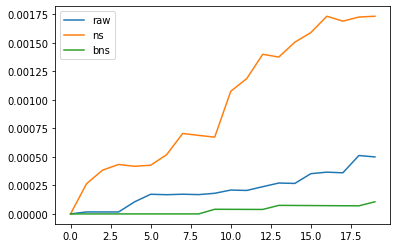

In [7]:
import matplotlib.pyplot as plt

def _f1(k, test, predict):
    """ Compute f1 score for each user

    :param k: int
    :param test: list of int
    :param predict: list of int
    :return tp_value: float
    """
    max_eval_size = min(k, len(predict)) # in case user has little candidate item
    tp = 0
    for i in range(max_eval_size):
        if predict[i] in test:
            tp += 1
    return 2*tp/(max_eval_size + len(test))


def f1(k, test_dict, pred_dict):
    res = []
    for user in test_dict:
        res.append(_f1(k, test_dict[user], pred_dict[user]))
    return sum(res)/len(test_dict)

k = 20
f1_raw = [f1(ki, rat_test_dict, pred_dict_raw) for ki in range(k)]
f1_p = [f1(ki, rat_test_dict, pred_dict_ns) for ki in range(k)]
f1_l = [f1(ki, rat_test_dict, pred_dict_bns) for ki in range(k)]

plt.plot(list(range(k)), f1_raw, label='raw')
plt.plot(list(range(k)), f1_p, label='ns')
plt.plot(list(range(k)), f1_l, label='bns')

plt.legend()

plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


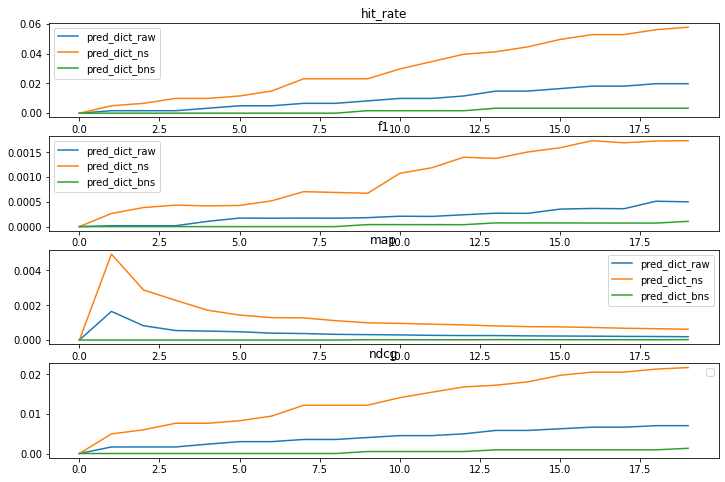

In [6]:
from eval.metric import hit_rate, f1, map, ndcg
import matplotlib.pyplot as plt

k = 20

metrics = {
    'hit_rate': hit_rate
    , 'f1': f1
    , 'map': map
    , 'ndcg': ndcg
}

preds = {
    'pred_dict_raw': pred_dict_raw
    , 'pred_dict_ns': pred_dict_ns
    , 'pred_dict_bns': pred_dict_bns
}

fig, ax = plt.subplots(4, figsize=(12, 8))
for i, m_i in enumerate(metrics.keys()):
    # val = [[metric(ki, rat_test_dict, pred)\
    #        for ki in range(k)]\
    #        for pred in preds.values()]
    val = [[metrics[m_i](ki, rat_test_dict, pred) \
            for pred in preds.values()]\
           for ki in range(k)]
    ax[i].plot(list(range(k)), val)
    ax[i].legend(list(preds.keys()))
    ax[i].set_title(m_i)

plt.legend()
plt.show()